아래의 Baseline 코드를 수정하여 업그레이드를 해보세요.
1. 새로운 컬럼 추가 하여 성능을 향상시켜 보세요. 체감온도, 불쾌지수 등..
2. 불필요한 컬럼을 제거하여 성능을 높이세요.
3. 머신러닝의 regression objective를 바꿔 성능을 향상시켜 보세요.
4. 하이퍼 파라메터 튜닝을 해보세요.

# 장재혁_2차_test 입니다.  
## 2. Modeling 아래에서 부터 코드를 썼습니다.

## 1. 데이터 전처리

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

train = pd.read_csv('train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv('test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])

sample_submission = pd.read_csv('sample_submission.csv', encoding='cp949')

In [3]:
train.info()
print('=' * 50)
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   num         122400 non-null  int64         
 1   date_time   122400 non-null  datetime64[ns]
 2   전력사용량(kWh)  122400 non-null  float64       
 3   기온(°C)      122400 non-null  float64       
 4   풍속(m/s)     122400 non-null  float64       
 5   습도(%)       122400 non-null  float64       
 6   강수량(mm)     122400 non-null  float64       
 7   일조(hr)      122400 non-null  float64       
 8   비전기냉방설비운영   122400 non-null  float64       
 9   태양광보유       122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [4]:
test.info()
print('=' * 50)
test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num           10080 non-null  int64         
 1   date_time     10080 non-null  datetime64[ns]
 2   기온(°C)        3360 non-null   float64       
 3   풍속(m/s)       3360 non-null   float64       
 4   습도(%)         3360 non-null   float64       
 5   강수량(mm, 6시간)  1680 non-null   float64       
 6   일조(hr, 3시간)   3360 non-null   float64       
 7   비전기냉방설비운영     2296 non-null   float64       
 8   태양광보유         1624 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 708.9 KB


num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

### 1-1. 결측치 처리

- train 데이터의 기간동안 비전기냉방설운영 형태나 태양광보유 상황이 달라지지 않은 것으로 보여, 현재의 값들로 test 데이터의 Null값을 채웁니다.
- 기온/풍속/습도/강수령/일조데이터는 선형보간으로 값을 채웁니다.

In [5]:
train.drop_duplicates(subset = ['num', '비전기냉방설비운영', '태양광보유']).dropna()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
2040,2,2020-06-01,977.184,18.3,2.5,94.0,0.0,0.0,1.0,0.0
4080,3,2020-06-01,3183.624,17.0,2.0,100.0,1.1,0.0,1.0,1.0
6120,4,2020-06-01,339.552,22.6,0.7,62.0,0.0,0.0,1.0,1.0
8160,5,2020-06-01,3063.744,18.3,2.5,94.0,0.0,0.0,1.0,0.0
10200,6,2020-06-01,527.580,17.0,2.0,100.0,1.1,0.0,0.0,0.0
12240,7,2020-06-01,1313.658,17.6,2.5,92.0,0.8,0.0,1.0,0.0
14280,8,2020-06-01,4801.977,19.1,1.1,73.0,0.0,0.0,1.0,1.0
16320,9,2020-06-01,1255.932,20.3,1.1,74.0,0.0,0.0,0.0,1.0
18360,10,2020-06-01,417.960,18.3,2.5,94.0,0.0,0.0,1.0,0.0


In [6]:
sun = train.groupby('num')['태양광보유'].unique()
non_ele = train.groupby('num')['비전기냉방설비운영'].unique()

In [7]:
test['태양광보유'] = test['num'].map(sun).astype(int)
test['비전기냉방설비운영'] = test['num'].map(non_ele).astype(int)

In [8]:
test = test.interpolate()
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0


### 1-2. feature engineering

In [9]:
# date_time에서 요일과 시간 추출
train['weekday'] = train['date_time'].dt.weekday + 1
train['hour'] = train['date_time'].dt.hour

test['weekday'] = test['date_time'].dt.weekday + 1
test['hour'] = test['date_time'].dt.hour

- 전력사용 패턴에 따른 건물별 clustering의 아이디어는 
[세아아부지](https://dacon.io/competitions/official/235736/codeshare/2643?page=1&dtype=recent)님의 Analytics를 참고했습니다.

In [10]:
#from sklearn.cluster import k_means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

d_list = []
for i in range(1, 61):
    d = train[train['num'] == i].copy()
    d['전력사용량(kWh)'] = scaler.fit_transform(d['전력사용량(kWh)'].values.reshape(-1,1))
    d_ = d.groupby(['weekday', 'hour'])['전력사용량(kWh)'].mean().unstack()
    d_list.append(d_.to_numpy())

# 정규화된 시간-요일별 전력사용량을 이미지처럼 저장
d_list = np.array(d_list)

In [11]:
d_list_ = d_list.reshape(60, -1)
model = KMeans(init="k-means++", n_clusters=4, random_state=0)
model.fit(d_list_)

KMeans(n_clusters=4, random_state=0)

In [12]:
cluster = model.labels_
pd.DataFrame(cluster)

,0
0,2
1,0
2,2
3,1
4,2
5,0
6,0
7,0
8,2
9,1


- K-means 군집화로 60개 건물의 시간-요일별 전력사용량 이미지를 4개로 분류했습니다.

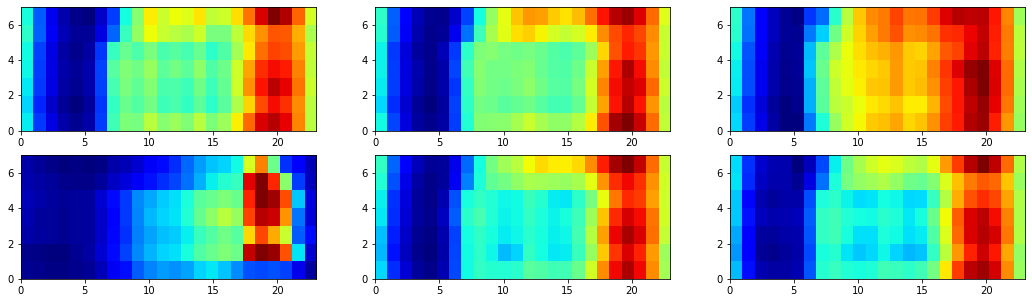

In [13]:
idx = cluster == 3
d_list = d_list.reshape(60, 7, 24)


fig, axes = plt.subplots(2, int(len(d_list[idx])/2), figsize = (18, 5))
axes = axes.flatten()

for d, ax in zip(d_list[idx], axes):
    d_ = scaler.inverse_transform(d)
    
    ax.imshow(d_, cmap = 'jet', aspect = 'auto', extent=[0, 23, 0, 7], origin = 'lower')

In [14]:
cluster_map = {i+1 : c for i, c in enumerate(cluster)}
train['cluster'] = train['num'].map(cluster_map)
test['cluster'] = test['num'].map(cluster_map)

## 2. Modeling
- K-fold와 lgbm으로 모델을 구성합니다

## 테스트 시작

In [15]:
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour',
       'cluster'],
      dtype='object')

In [16]:
test.columns

Index(['num', 'date_time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)',
       '일조(hr, 3시간)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster'],
      dtype='object')

In [17]:
train.isnull().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
weekday       0
hour          0
cluster       0
dtype: int64

In [18]:
test.isnull().sum()

num             0
date_time       0
기온(°C)          0
풍속(m/s)         0
습도(%)           0
강수량(mm, 6시간)    0
일조(hr, 3시간)     0
비전기냉방설비운영       0
태양광보유           0
weekday         0
hour            0
cluster         0
dtype: int64

In [19]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour,cluster
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,2
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,2
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,2
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,2


In [20]:
train.filter(regex='hr', axis=1)

,일조(hr)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
122395,0.7
122396,0.0
122397,0.0
122398,0.0


In [21]:
train.filter(regex='비전기냉방설비운영', axis=1)

,비전기냉방설비운영
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
122395,1.0
122396,1.0
122397,1.0
122398,1.0


<AxesSubplot:>

C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\A\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text

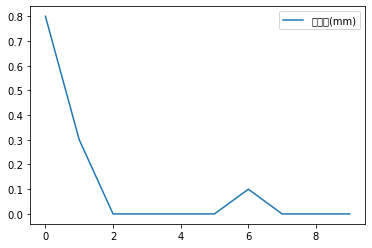

In [22]:
train.filter(regex='강수량', axis='columns').head(10).plot()

In [23]:
# 연월일주 컬럼 추가 주 컬럼 에러 방지용으로 .astype(int) 사용
train['datetime_year'] = train['date_time'].dt.year
train['datetime_month'] = train['date_time'].dt.month
train['datetime_day'] = train['date_time'].dt.day
train['datetime_week'] = train['date_time'].dt.isocalendar().week
train['datetime_week'] = train['datetime_week'].astype(int)
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,weekday,hour,cluster,datetime_year,datetime_month,datetime_day,datetime_week
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,1,0,2,2020,6,1,23
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,1,2,2020,6,1,23
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,1,2,2,2020,6,1,23
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,1,3,2,2020,6,1,23
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,1,4,2,2020,6,1,23


In [24]:
# 연월일 주 컬럼 추가 주 컬럼 에러 방지용으로 .astype(int) 사용
test['datetime_year'] = test['date_time'].dt.year
test['datetime_month'] = test['date_time'].dt.month
test['datetime_day'] = test['date_time'].dt.day
test['datetime_week'] = test['date_time'].dt.isocalendar().week
test['datetime_week'] = test['datetime_week'].astype(int)
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,weekday,hour,cluster,datetime_year,datetime_month,datetime_day,datetime_week
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0,0,2,0,2,2020,8,25,35
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0,0,2,1,2,2020,8,25,35
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0,0,2,2,2,2020,8,25,35
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0,0,2,3,2,2020,8,25,35
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0,0,2,4,2,2020,8,25,35


In [25]:
# 불쾌지수 컬럼 THI 추가
train['THI'] = 1.8*train['기온(°C)']-0.55*(1-train['습도(%)']/100)*(1.8*train['기온(°C)']-26)+32
train[['기온(°C)', '습도(%)', 'THI']]

,기온(°C),습도(%),THI
0,17.6,92.0,63.43008
1,17.7,91.0,63.56993
2,17.5,91.0,63.22775
3,17.1,91.0,62.54339
4,17.0,92.0,62.39760
...,...,...,...
122395,27.8,68.0,77.80896
122396,27.3,71.0,77.44917
122397,27.3,71.0,77.44917
122398,27.1,74.0,77.52246


In [26]:
# 불쾌지수단계 컬럼 THI_Type 추가
train.loc[train['THI']<68, 'THI_Type'] = 1
train.loc[(train['THI']>=68)&(train['THI']<75), 'THI_Type'] = 2
train.loc[(train['THI']>=75)&(train['THI']<80), 'THI_Type'] = 3
train.loc[train['THI']>=80, 'THI_Type'] = 4
train[['THI', 'THI_Type']]

,THI,THI_Type
0,63.43008,1.0
1,63.56993,1.0
2,63.22775,1.0
3,62.54339,1.0
4,62.39760,1.0
...,...,...
122395,77.80896,3.0
122396,77.44917,3.0
122397,77.44917,3.0
122398,77.52246,3.0


In [27]:
# 불쾌지수 컬럼 THI 추가
test['THI'] = 1.8*test['기온(°C)']-0.55*(1-test['습도(%)']/100)*(1.8*test['기온(°C)']-26)+32
# 불쾌지수단계 컬럼 THI_Type 추가
test.loc[test['THI']<68, 'THI_Type'] = 1
test.loc[(test['THI']>=68)&(test['THI']<75), 'THI_Type'] = 2
test.loc[(test['THI']>=75)&(test['THI']<80), 'THI_Type'] = 3
test.loc[test['THI']>=80, 'THI_Type'] = 4
test[['THI', 'THI_Type']]

,THI,THI_Type
0,78.602280,3.0
1,78.519273,3.0
2,78.431867,3.0
3,78.340060,3.0
4,77.912697,3.0
...,...,...
10075,78.764020,3.0
10076,78.364280,3.0
10077,77.957280,3.0
10078,77.957280,3.0


In [56]:
# 휴일 holiday 컬럼 추가
special_days = ['2020-06-06', '2020-08-15', '2020-08-17']
train['holiday'] = 0
train.loc[train['date_time'].isin(special_days), 'holiday'] = 1
train.loc[train['weekday']>=6, 'holiday'] = 1
train.loc[train['date_time']=='2020-06-06'][['date_time', 'weekday', 'holiday']]

,date_time,weekday,holiday
120,2020-06-06,6,1
2160,2020-06-06,6,1
4200,2020-06-06,6,1
6240,2020-06-06,6,1
8280,2020-06-06,6,1
10320,2020-06-06,6,1
12360,2020-06-06,6,1
14400,2020-06-06,6,1
16440,2020-06-06,6,1
18480,2020-06-06,6,1


In [69]:
# 휴일 holiday 컬럼 추가
special_days = ['2020-06-06', '2020-08-15', '2020-08-17']
test['holiday'] = 0
test.loc[test['date_time'].isin(special_days), 'holiday'] = 1
test.loc[test['weekday']>=6, 'holiday'] = 1
test.loc[test['weekday']==1][['date_time', 'weekday', 'holiday']]

,date_time,weekday,holiday
144,2020-08-31 00:00:00,1,0
145,2020-08-31 01:00:00,1,0
146,2020-08-31 02:00:00,1,0
147,2020-08-31 03:00:00,1,0
148,2020-08-31 04:00:00,1,0
...,...,...,...
10075,2020-08-31 19:00:00,1,0
10076,2020-08-31 20:00:00,1,0
10077,2020-08-31 21:00:00,1,0
10078,2020-08-31 22:00:00,1,0


In [30]:
# 체감 온도 컬럼 atemp 추가
train['atemp'] = 13.12+(0.6215*train['기온(°C)'])-(11.37*train['풍속(m/s)']**0.16)+(0.3965*train['기온(°C)']*train['풍속(m/s)']**0.16)
train[['기온(°C)', 'atemp']]

,기온(°C),atemp
0,17.6,18.973374
1,17.7,18.960338
2,17.5,18.658598
3,17.1,18.218957
4,17.0,18.081523
...,...,...
122395,27.8,30.000891
122396,27.3,29.525251
122397,27.3,29.487603
122398,27.1,29.276183


In [31]:
# 체감 온도 컬럼 atemp 추가
test['atemp'] = 13.12+(0.6215*test['기온(°C)'])-(11.37*test['풍속(m/s)']**0.16)+(0.3965*test['기온(°C)']*test['풍속(m/s)']**0.16)
test[['기온(°C)', 'atemp']]

,기온(°C),atemp
0,27.800000,30.027122
1,27.633333,29.859547
2,27.466667,29.694705
3,27.300000,29.533017
4,26.900000,29.116617
...,...,...
10075,28.633333,30.894924
10076,28.266667,30.486546
10077,27.900000,30.074281
10078,27.900000,30.074281


In [32]:
# 기온 - 체감온도의 temp_diff 추가
train['temp_diff'] = train['기온(°C)'] - train['atemp']
train[['기온(°C)', 'atemp', 'temp_diff']]

,기온(°C),atemp,temp_diff
0,17.6,18.973374,-1.373374
1,17.7,18.960338,-1.260338
2,17.5,18.658598,-1.158598
3,17.1,18.218957,-1.118957
4,17.0,18.081523,-1.081523
...,...,...,...
122395,27.8,30.000891,-2.200891
122396,27.3,29.525251,-2.225251
122397,27.3,29.487603,-2.187603
122398,27.1,29.276183,-2.176183


In [33]:
# 기온 - 체감온도의 temp_diff 추가
test['temp_diff'] = test['기온(°C)'] - test['atemp']
test[['기온(°C)', 'atemp', 'temp_diff']]

,기온(°C),atemp,temp_diff
0,27.800000,30.027122,-2.227122
1,27.633333,29.859547,-2.226214
2,27.466667,29.694705,-2.228038
3,27.300000,29.533017,-2.233017
4,26.900000,29.116617,-2.216617
...,...,...,...
10075,28.633333,30.894924,-2.261590
10076,28.266667,30.486546,-2.219879
10077,27.900000,30.074281,-2.174281
10078,27.900000,30.074281,-2.174281


In [34]:
train.columns

Index(['num', 'date_time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)',
       '강수량(mm)', '일조(hr)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster',
       'datetime_year', 'datetime_month', 'datetime_day', 'datetime_week',
       'THI', 'THI_Type', 'holiday', 'atemp', 'temp_diff'],
      dtype='object')

In [35]:
test.columns

Index(['num', 'date_time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)',
       '일조(hr, 3시간)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster',
       'datetime_year', 'datetime_month', 'datetime_day', 'datetime_week',
       'THI', 'THI_Type', 'holiday', 'atemp', 'temp_diff'],
      dtype='object')

<AxesSubplot:>

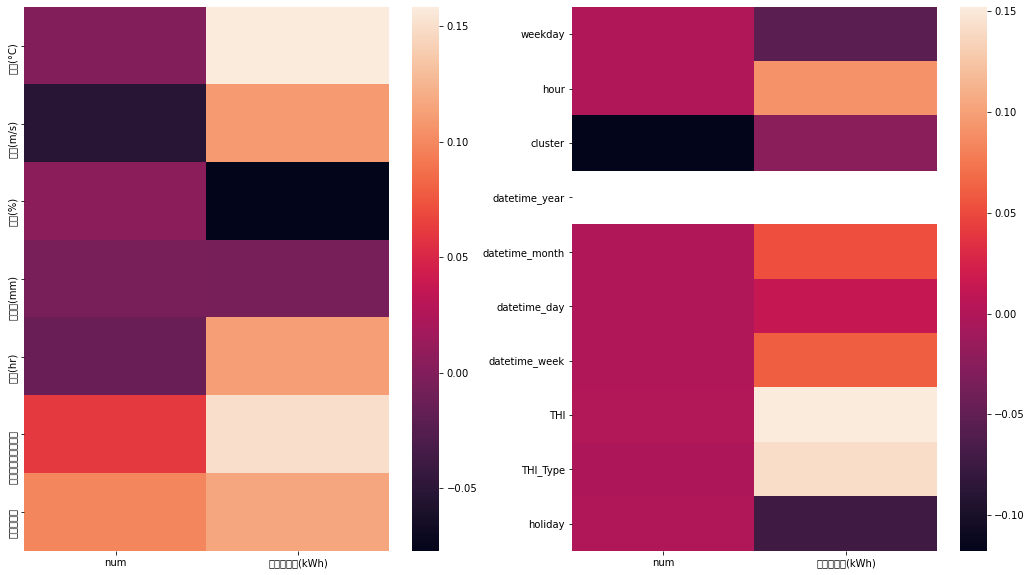

In [59]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 10)
sns.heatmap(train.corr().loc['기온(°C)':'태양광보유', 'num':'전력사용량(kWh)'], ax=ax1)
sns.heatmap(train.corr().loc['weekday':'holiday', 'num':'전력사용량(kWh)'], ax=ax2)

In [43]:
# import 부분 이동
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

In [61]:
# datetime_year 컬럼이 히트맵 상 하얗게 나와 불필요해 보여 제거
X = train.drop(['date_time', '전력사용량(kWh)','datetime_year',], axis = 1)
y = train['전력사용량(kWh)']
X_test = test.drop(['date_time','datetime_year',], axis = 1)

In [62]:
test.columns

Index(['num', 'date_time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)',
       '일조(hr, 3시간)', '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster',
       'datetime_year', 'datetime_month', 'datetime_day', 'datetime_week',
       'THI', 'THI_Type', 'holiday', 'atemp', 'temp_diff'],
      dtype='object')

In [66]:
X.columns

Index(['num', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영',
       '태양광보유', 'weekday', 'hour', 'cluster', 'datetime_month', 'datetime_day',
       'datetime_week', 'THI', 'THI_Type', 'holiday', 'atemp', 'temp_diff'],
      dtype='object')

In [67]:
X_test.columns

Index(['num', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)', '일조(hr, 3시간)',
       '비전기냉방설비운영', '태양광보유', 'weekday', 'hour', 'cluster', 'datetime_month',
       'datetime_day', 'datetime_week', 'THI', 'THI_Type', 'holiday', 'atemp',
       'temp_diff'],
      dtype='object')

In [225]:
order = [[0]]
columns = ['kwh']
output = pd.DataFrame(order, columns=columns)
output

,kwh
0,0


In [231]:
coarse_hyperparameters_list = []

num_epoch = 3 # 오래 걸려 조금만 시도

for epoch in range(num_epoch):
    #hyperparameter 세팅
    max_depth = np.random.randint(low=-1, high=30)
    leaves = np.random.randint(low=1, high=14)
    num_leaves = 2**leaves
    # 0.001, 0.01, 0.1에 동등한 확률의 기회를 주기 위해 지수 개념으로 랜덤 추출이 필요함.
    lr = np.random.uniform(low=1, high=4)
    learning_rate = 3*(10**(-lr))

    colsample_bytree = np.random.uniform(low=0.4, high=1)
    subsample = np.random.uniform(low=0.4, high=1)

    r_alpha = np.random.uniform(low=0, high=100)
    r_lambda = np.random.uniform(low=0, high=100)

    n_splits = 5
    sfk = StratifiedKFold(n_splits = n_splits)
    result = 0

    y_pred = np.zeros(len(X_test))

    # train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
    for tr_idx, val_idx in sfk.split(X, X['num']):      
        print(result)
        X_train = X.iloc[tr_idx, :]
        y_train = y[tr_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y[val_idx]

        lgbm = LGBMRegressor(random_state=18, n_estimators=10000, boosting_type='gbdt', objective='mse',
                                      max_depth=max_depth, num_leaves=num_leaves, colsample_bytree=colsample_bytree,
                                     learning_rate=learning_rate, reg_alpha=r_alpha, reg_lambda=r_lambda, subsample=subsample)
        lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'mse', early_stopping_rounds= 50,verbose = -1)
        y_pred += lgbm.predict(X_test) / n_splits
        val_pred = lgbm.predict(X_val)

        result += np.mean((np.abs(y_val - val_pred))) / n_splits
        print(result)
        
    output[columns[0]] = result
        
    #####################################################################
                                     
    scores = output.loc[0].mean() #평가지표
                                      
    hyperparameters = {'epoch':epoch, 
                       'socres':scores, 
                       'lr':lr,
                       'max_depth':max_depth, 
                       'num_leaves':num_leaves,
                       'colsample_bytree':colsample_bytree,
                       'subsample':subsample,
                       'reg_alpha':r_alpha,
                       'reg_lambda':r_lambda}
                                  
    coarse_hyperparameters_list.append(hyperparameters) # scores에 대한 hyoerparameter 값을 기록
   
    # {변수:int}에서  int는 변수의 자리수를 뜻함 {변수:.숫자f}에서 .숫자는 변수의 소숫점 자리수를 뜻함
    print(f'{epoch:2},scores={scores:.4f},lr={lr:.4f},max_depth={max_depth:2},num_leaves={num_leaves:2},colsample_bytree={colsample_bytree:.4f},subsample={subsample:.4f},r_alpha={r_alpha:.4f},r_lambda={r_lambda:.4f}')
                                      
coarse_hyperparameters_dataframe = pd.DataFrame.from_dict(coarse_hyperparameters_list) # hyperparameters dataframe화
coarse_hyperparameters_dataframe = coarse_hyperparameters_dataframe.sort_values(by='socres') #오름차순 정렬, 가장 좋은 결과 상단
print(coarse_hyperparameters_dataframe.shape)
coarse_hyperparameters_dataframe.head(10) # top 10

0
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[9997]	valid_0's l2: 129440
46.33249578393817
46.33249578393817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5963]	valid_0's l2: 144411
93.99519269418627
93.99519269418627
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l2: 130449
139.00558095374984
139.00558095374984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7380]	valid_0's l2: 163414
189.38697526264906
189.38697526264906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6740]	valid_0's l2: 253822
250.6865077806088
 0,scores=250.6865,lr=1.7800,max_depth=16,num_leaves= 4,colsample_bytree=0.9156,subsample=0.8194,r_alpha=15.4185,r_lambda=17.8960
0
Training until validation scores don't improve for 50 

,epoch,socres,lr,max_depth,num_leaves,colsample_bytree,subsample,reg_alpha,reg_lambda
2,2,188.266852,2.129512,15,8192,0.438618,0.718062,64.222008,15.922826
1,1,202.994380,3.075918,6,1024,0.780765,0.941518,67.889167,49.012307
0,0,250.686508,1.779960,16,4,0.915574,0.819379,15.418536,17.895993


In [65]:
n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)
result = 0

y_pred = np.zeros(len(X_test))

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X, X['num']):      
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    lgbm = LGBMRegressor(random_state=18, n_estimators=10000, boosting_type='gbdt', objective='mse',
                                  max_depth=-1, num_leaves=110, colsample_bytree=0.9,
                                  learning_rate=0.01, reg_alpha=3, reg_lambda=3, subsample=0.9)
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'mse', early_stopping_rounds= 50,verbose = -1)
    y_pred += lgbm.predict(X_test) / n_splits
    val_pred = lgbm.predict(X_val)

    result += np.mean((np.abs(y_val - val_pred))) / n_splits
    print(result)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3843]	valid_0's l2: 66599.6
28.749728114787167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4919]	valid_0's l2: 33819.6
50.83957375633621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4105]	valid_0's l2: 44060.8
73.65300137657661
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1869]	valid_0's l2: 46236.3
99.66709937549292
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3807]	valid_0's l2: 119961
135.6954329121935


In [262]:
submission = sample_submission.copy()
submission['answer'] = y_pred

In [263]:
submission.to_csv('sub_210611-2.csv', index= False)

# 최종 요약

## 9 컬럼 추가 
'THI', 'THI_Type', 'atemp', 'temp_diff', 'datetime_year','datetime_month', 'datetime_day', 'datetime_week', 'holiday'

## 불필요해 보이는 컬럼 제거
'datetime_year'

## regression objective 변경 시도
mse, rmse, mae, mepe 4가지 사용해봤습니다.

## hyperparameter tuning
random_state=18, n_estimators=10000, boosting_type='gbdt', objective='mse', max_depth=-1, num_leaves=110, colsample_bytree=0.9,                         learning_rate=0.01, reg_alpha=3, reg_lambda=3, subsample=0.9

## 많이 부족하지만 시도한 케이스 중 우수한 것 같은  케이스 입니다.
## 감사합니다.
